# BT 5153: Team Loren Ipsum - Image tagging system: Electronics Category only

## Reading Datasets and importing library
* The merged data file uploaded here is a 75 MB file which was created from the original datasets downloaded from this link: https://nijianmo.github.io/amazon/index.html
* This merged file was created using 2 files downloaded from the above link: 1. The review file, which contains the review data of a product and 2. The product metadata file, which contains information about the product
    * The review file has been chosen to incorporate "realism" into our dataset. Images from review file are images that we expect from users to be uploaded onto a C2C second-hand marketplace portal

In [1]:
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re #for splitting tags
import urllib #Extracting images from url's
import cv2   #For image processing
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss
from multiprocessing.pool import Pool
import gc

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bt5153-mergeddata/mergeddata.csv


In [2]:
# Reading merged data (Merging of metadata and review data at product level)
df = pd.read_csv('/kaggle/input/bt5153-mergeddata/mergeddata.csv')

In [3]:
print(len(df))
print(df.head)

112066
<bound method NDFrame.head of               asin                                      review_images  \
0       0511189877  ['https://images-na.ssl-images-amazon.com/imag...   
1       0972683275  ['https://images-na.ssl-images-amazon.com/imag...   
2       0972683275  ['https://images-na.ssl-images-amazon.com/imag...   
3       0972683275  ['https://images-na.ssl-images-amazon.com/imag...   
4       0972683275  ['https://images-na.ssl-images-amazon.com/imag...   
...            ...                                                ...   
112061  B01HICMC3A  ['https://images-na.ssl-images-amazon.com/imag...   
112062  B01HICMC3A  ['https://images-na.ssl-images-amazon.com/imag...   
112063  B01HIS365W  ['https://images-na.ssl-images-amazon.com/imag...   
112064  B01HIW2XPM  ['https://images-na.ssl-images-amazon.com/imag...   
112065  B01HIYOC0E  ['https://images-na.ssl-images-amazon.com/imag...   

                                                 category  \
0       ['Electronics', '

## Generating and Keeping only relevant tags (using Count Vectoriser)
* We use the "category" column of the dataset above to generate tags. Tags which appear atleast 5% of the times across entire dataset are considered

In [4]:
# Data might have duplicate rows due to multiple images for same product - creating a category dataset with unique product and category

df_cat = df[['asin','category']]
df_cat.drop_duplicates(inplace = True)
#df_cat.reset_index()
df_cat.head()

print("Unique products with their categories are:", len(df_cat))
print(df_cat)

Unique products with their categories are: 39965
              asin                                           category
0       0511189877  ['Electronics', 'Accessories & Supplies', 'Aud...
1       0972683275  ['Electronics', 'Accessories & Supplies', 'Aud...
8       106171327X  ['Electronics', 'Computers & Accessories', 'Co...
10      140053271X  ['Electronics', 'eBook Readers & Accessories',...
11      1400501466  ['Electronics', 'Computers & Accessories', 'Co...
...            ...                                                ...
112060  B01HI9ZK8M  ['Electronics', 'Accessories & Supplies', 'Aud...
112061  B01HICMC3A  ['Electronics', 'Computers & Accessories', 'Ne...
112063  B01HIS365W  ['Electronics', 'Computers & Accessories', 'Co...
112064  B01HIW2XPM  ['Electronics', 'Computers & Accessories', 'Co...
112065  B01HIYOC0E  ['Electronics', 'Accessories & Supplies', 'Cor...

[39965 rows x 2 columns]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [5]:
def my_tokenizer(s):
    s = re.split(', ',s) #Seperate tags after each comma
    return s

# Replace initial and starting and '\'' characters
df_cat['category'] = df_cat['category'].apply(lambda x: x.replace('[','').replace(']','').replace('\'',''))

# Implementing vectoriser - without any 
vec = CountVectorizer(tokenizer = my_tokenizer, 
                      lowercase = True,
                      min_df = 0.05, # Should appear as a tag in atleast 5% of all products
                      max_features = 100,  # a maximum of top 250 tags after the above exclusion will be considered,
                      stop_words = ['electronics'] #THIS STOP-WORD WOULD NOT BE USED ONCE EXPANDING ONTO OTHER CATEGORIES
                     )
X = vec.fit_transform(df_cat['category'])
tags = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

# Some tags are repeating causing vectoriser > 1 --> they are being replaced by 1
tags.mask(tags > 1, 1, inplace = True)

print(tags.head())
print("~2100 individual tags are now reduced to: ",tags.shape)
                   
# Joining tags to df_cat
df_vectoriser = pd.concat([df_cat.reset_index(drop=True),tags.reset_index(drop=True)], axis = 1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


   accessories  accessories & supplies  audio & video accessories  bags  \
0            0                       1                          1     0   
1            0                       1                          1     0   
2            0                       0                          0     0   
3            0                       0                          0     0   
4            0                       0                          0     0   

   cables & interconnects  camera & photo  cases & sleeves  \
0                       0               0                0   
1                       0               0                0   
2                       0               0                0   
3                       0               0                0   
4                       0               0                0   

   computer accessories & peripherals  computer components  \
0                                   0                    0   
1                                   0               

In [6]:
## Viewing concat dataset
df_vectoriser

,asin,category,accessories,accessories & supplies,audio & video accessories,bags,cables & interconnects,camera & photo,cases & sleeves,computer accessories & peripherals,computer components,computers & accessories,headphones,laptop accessories,portable audio & video,tablet accessories
0,0511189877,"Electronics, Accessories & Supplies, Audio & V...",0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,0972683275,"Electronics, Accessories & Supplies, Audio & V...",0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,106171327X,"Electronics, Computers & Accessories, Computer...",0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,140053271X,"Electronics, eBook Readers & Accessories, eBoo...",0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1400501466,"Electronics, Computers & Accessories, Computer...",0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39960,B01HI9ZK8M,"Electronics, Accessories & Supplies, Audio & V...",0,1,1,0,0,0,0,0,0,0,0,0,0,0
39961,B01HICMC3A,"Electronics, Computers & Accessories, Networki...",0,0,0,0,0,0,0,0,0,1,0,0,0,0
39962,B01HIS365W,"Electronics, Computers & Accessories, Computer...",0,0,0,0,0,0,0,1,0,1,0,0,0,0
39963,B01HIW2XPM,"Electronics, Computers & Accessories, Computer...",0,0,0,0,0,0,0,0,1,1,0,0,0,0


## Building model

In [7]:
# Libraries for building model
import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.applications import densenet, VGG16

Using TensorFlow backend.


### Some more data manipulation (Sequential steps)
* This is done because each row has multiple URL's of images, so each URL becomes 1 row of data
* Only keep products which have > 4 "metadata" images - this check is introduced to ensure that products are genuine and the seller has put some effort to list the product online
* Randomly selecting 5 images from metadata and 2 image from the review data: This is done because downloading all the images causes memory overflow

In [8]:
# We have observed multiple review Url's for 1 product, so dataset is exploded such that each URL becomes a row
df_url1 = df[['asin','review_images']]
df_url1 = df_url1.drop_duplicates().reset_index(drop = True)
df_url2 = df[['asin','clean_image']]
df_url2 = df_url2.drop_duplicates().reset_index(drop = True)
url_clean1 = lambda x: x['review_images'].replace('\'','').replace('[','').replace(']','')
url_clean2 = lambda x: x['clean_image'].replace('\'','').replace('[','').replace(']','')
df_url1['clean_review_url'] = df_url1.apply(url_clean1, axis = 1)
df_url2['clean_metadata_url'] = df_url2.apply(url_clean2, axis = 1)
new_df1 = pd.DataFrame(df_url1.clean_review_url.str.split(', ').tolist(), index=df_url1.asin).stack()  
new_df2 = pd.DataFrame(df_url2.clean_metadata_url.str.split(', ').tolist(), index=df_url2.asin).stack()

new_df1 = new_df1.reset_index([0, 'asin'])
new_df1.columns = ['asin', 'image']
new_df2 = new_df2.reset_index([0, 'asin'])
new_df2.columns = ['asin', 'image']


# Taking only jpg images 
new_df1 = new_df1[new_df1.image.str.contains(".jpg")]
new_df2 = new_df2[new_df2.image.str.contains(".jpg")]

# Removing play-icon images
new_df1 = new_df1[~new_df1.image.str.contains("play")]
new_df2 = new_df2[~new_df2.image.str.contains("play")]

In [9]:
# Checking for products which have > 4 metadata image
counts = pd.DataFrame(new_df2.asin.value_counts().reset_index(drop = False))
counts_selected = counts[counts.asin > 4]
asin_selected_meta = counts_selected['index']

In [10]:
# Filtering for products with atleast 5 metadata images
new_df1 = new_df1[new_df1.asin.isin(asin_selected_meta)]
new_df2 = new_df2[new_df2.asin.isin(asin_selected_meta)]

# Randomly sampling 5 images for a product from metadata and 2 image from review data
grouped_1 = new_df1.groupby('asin')
new_df1_group = grouped_1.apply(lambda x: x.sample(n=2, replace = True))
new_df1_group = new_df1_group[['asin','image']].reset_index(drop = True)
grouped_2 = new_df2.groupby('asin')
new_df2_group = grouped_2.apply(lambda x: x.sample(n=5, replace = False))
new_df2_group = new_df2_group[['asin','image']].reset_index(drop = True)

new_df = pd.concat([new_df1_group, new_df2_group])
print(new_df)

              asin                                              image
0       0972683275  https://images-na.ssl-images-amazon.com/images...
1       0972683275  https://images-na.ssl-images-amazon.com/images...
2       8866139874  https://images-na.ssl-images-amazon.com/images...
3       8866139874  https://images-na.ssl-images-amazon.com/images...
4       9966633383  https://images-na.ssl-images-amazon.com/images...
...            ...                                                ...
124000  B01HJDNL60  https://images-na.ssl-images-amazon.com/images...
124001  B01HJDNL60  https://images-na.ssl-images-amazon.com/images...
124002  B01HJDNL60  https://images-na.ssl-images-amazon.com/images...
124003  B01HJDNL60  https://images-na.ssl-images-amazon.com/images...
124004  B01HJDNL60  https://images-na.ssl-images-amazon.com/images...

[173475 rows x 2 columns]


In [11]:
# Merging our tags dataset with the above created data to obtain final dataset
df_model = new_df.merge(df_vectoriser, how = 'left',on = 'asin')
print(df_model.head())
print(df_model.shape)

         asin                                              image  \
0  0972683275  https://images-na.ssl-images-amazon.com/images...   
1  0972683275  https://images-na.ssl-images-amazon.com/images...   
2  8866139874  https://images-na.ssl-images-amazon.com/images...   
3  8866139874  https://images-na.ssl-images-amazon.com/images...   
4  9966633383  https://images-na.ssl-images-amazon.com/images...   

                                            category  accessories  \
0  Electronics, Accessories & Supplies, Audio & V...            0   
1  Electronics, Accessories & Supplies, Audio & V...            0   
2  Electronics, eBook Readers & Accessories, Read...            0   
3  Electronics, eBook Readers & Accessories, Read...            0   
4  Electronics, Computers & Accessories, Computer...            0   

   accessories & supplies  audio & video accessories  bags  \
0                       1                          1     0   
1                       1                          1

In [12]:
# create funtion to generate an image from URL and plot it
def show_image_from_url(image_url):

  """
  Fetches image online from the image_url and plots it as it is using matplotlib's pyplot's image show
  """
  image_url = image_url.replace('\'','').replace('[','').replace(']','')
  #for url in image_url:
  response = urllib.request.urlopen(image_url)
  image = np.asarray(bytearray(response.read()), dtype="uint8")
  image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb)#, plt.axis('off')

In [13]:
# Ploting multiple review images of same object
counts = df_model.asin.value_counts()
counts

B00RBG7W52    7
B00DMHZWUQ    7
B01D9FEV2K    7
B00KRM60PK    7
B00UNDF7IY    7
             ..
B001ULD4L0    5
B0075W8D7I    5
B003R7KLUM    5
B0018TCB0O    5
B000BFQ3YG    5
Name: asin, Length: 24801, dtype: int64

['https://images-na.ssl-images-amazon.com/images/I/81zCVbwJOcL._SY88.jpg'
 'https://images-na.ssl-images-amazon.com/images/I/81KYDqLrZyL._SY88.jpg'
 'https://images-na.ssl-images-amazon.com/images/I/41stZf6fMyL._SS40_.jpg'
 'https://images-na.ssl-images-amazon.com/images/I/41xhBt%2BWtiL._SS40_.jpg'
 'https://images-na.ssl-images-amazon.com/images/I/413SiOJeoAL._SS40_.jpg'
 'https://images-na.ssl-images-amazon.com/images/I/41Viliz%2BcOL._SS40_.jpg'
 'https://images-na.ssl-images-amazon.com/images/I/41Oj3NDRUTL._SS40_.jpg']
Category of the image is:  Electronics, Computers & Accessories, Laptop Accessories, Bags, Cases & Sleeves, Messenger Bags


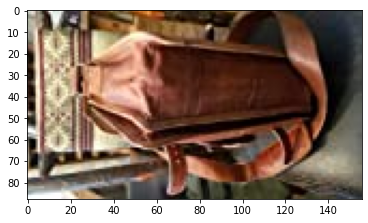

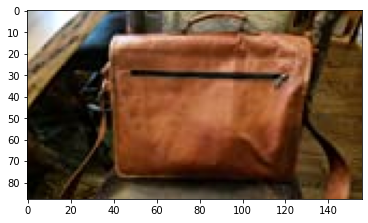

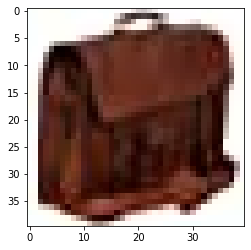

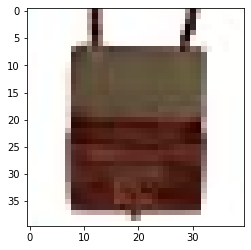

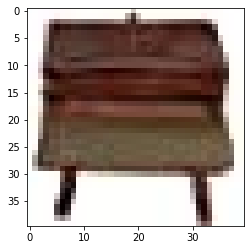

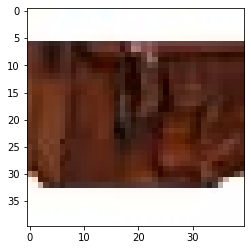

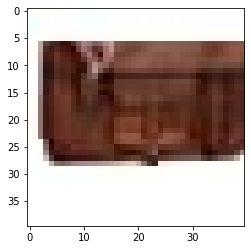

In [14]:
# Plotting multiple images for object B004WB8EYM
obj_image = df_model.loc[df_model.asin == 'B00FR0JMNE'].reset_index(drop = True)
#print(obj_image)
# Ensuring links are different 
print(obj_image.image.values)
print("Category of the image is: ", obj_image['category'].loc[0])
i = 0
for i in range(7):
    plt.figure()
    show_image_from_url(obj_image['image'].loc[i])

### Some problems with using just review data - review images for camera is people putting in random "clicked" photos

In [15]:
# Ploting multiple review images of same object
counts = new_df1.asin.value_counts()
counts

B00I8BICCG    271
B00U2W4JEY    238
B005MTMFHU    233
B00DIF2BO2    220
B001S2PPT0    202
             ... 
B00UYO4VWA      1
B00TKLFA6O      1
B01H6SBMB4      1
B0050JSJU4      1
B00BP8VIXY      1
Name: asin, Length: 24735, dtype: int64

Category of the image is:  ["['Electronics', 'Camera & Photo', 'Digital Cameras', 'Mirrorless Cameras']"]


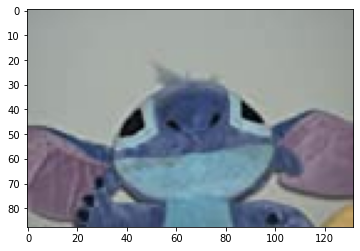

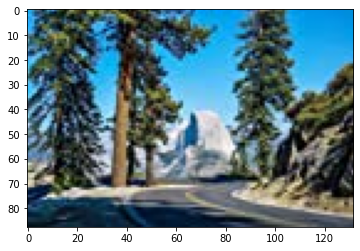

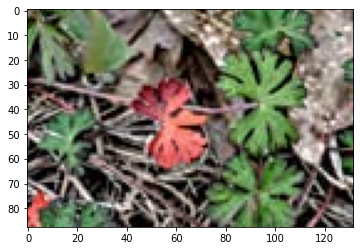

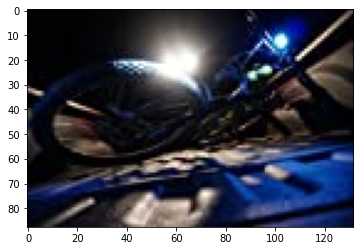

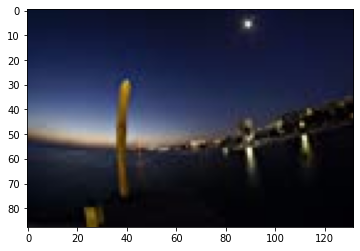

In [16]:
### THIS PART SHOWS THE PROBLEMS WITH SOME PRODUCTS - SUCH AS CAMERA PHOTOS BEING RANDOMLY TAKEN PHOTOS
# Plotting images for object B00007E7JU
obj_image = new_df1.loc[new_df1.asin == 'B00I8BICCG'].reset_index(drop = True)
#print(obj_image)
print("Category of the image is: ", df.loc[df.asin == 'B00I8BICCG']['category'].head(1).values)
for i in range(5):
    plt.figure()
    #print(obj_image['image'].values)
    show_image_from_url(obj_image['image'].loc[random.randint(0,len(obj_image)-1)])

### Getting arrays for images out

In [17]:
#create function to obtain image data and convert into generator
def get_image_data(img_url):

    try:
    #Download from image url and import it as a numpy array
        response = urllib.request.urlopen(img_url)
        image = np.asarray(bytearray(response.read()), dtype="uint8")

    #Read the numpy arrays as color images in OpenCV
        image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)
    
    #Resize the image to 35x35x3 pixels size - review images are much bigger -> but they have been converted as well 
        if image.shape[0]> 1000:
            image = cv2.resize(image_bgr, (35, 35))
        else:
            image = np.nan
        return (img_url,image)
    except:
        return None

In [18]:
%%time
# Cleaning garbage values
gc.collect()

# Final check to enusre no NA's remain
df_model = df_model.dropna(how = 'any')

# Looping through batch of 10000 URL's to help keep track
n_loops = len(df_model)//10000
print(n_loops)
len_df = len(df_model)
append_df = pd.DataFrame(columns = ['image','loaded_img'])

for i in range(n_loops+1):
# Applying Image generator
    if i * 10000 + 10000 < len(df_model):
        urls = df_model[i*10000:i*10000+10000].image.values
        result = pd.DataFrame(Pool(10).map(get_image_data, urls), columns = ['image','loaded_img'])
        append_df = append_df.append(result, True)
    else:
        urls = df_model[i*10000:len_df+1].image.values
        result = pd.DataFrame(Pool(10).map(get_image_data, urls), columns = ['image','loaded_img'])
        append_df = append_df.append(result, True)   
    print(i, "Complete!")   

# Merging appended image dataset to one-hot encoded tags dataset
df_model_final = df_model.merge(append_df, how = 'left', on = 'image')
df_model_final = df_model_final.dropna(how = 'any')
df_model_final.shape
df_model_final.to_csv("Model_Input_data_35x35_14tags.csv", index = False)

17
0 Complete!
1 Complete!
2 Complete!
3 Complete!
4 Complete!
5 Complete!
6 Complete!
7 Complete!
8 Complete!
9 Complete!
10 Complete!
11 Complete!
12 Complete!
13 Complete!
14 Complete!
15 Complete!
16 Complete!
17 Complete!
CPU times: user 1min 56s, sys: 23 s, total: 2min 19s
Wall time: 39min 27s


Process ForkPoolWorker-179:
Process ForkPoolWorker-24:
Process ForkPoolWorker-50:
Process ForkPoolWorker-2:
Process ForkPoolWorker-32:
Process ForkPoolWorker-72:
Process ForkPoolWorker-21:
Process ForkPoolWorker-97:
Process ForkPoolWorker-94:
Process ForkPoolWorker-112:
Process ForkPoolWorker-69:
Process ForkPoolWorker-65:
Process ForkPoolWorker-59:
Process ForkPoolWorker-46:
Process ForkPoolWorker-9:
Process ForkPoolWorker-83:
Process ForkPoolWorker-41:
Process ForkPoolWorker-33:
Process ForkPoolWorker-45:
Process ForkPoolWorker-79:
Process ForkPoolWorker-42:
Process ForkPoolWorker-115:
Process ForkPoolWorker-60:
Process ForkPoolWorker-6:
Process ForkPoolWorker-173:
Process ForkPoolWorker-126:
Process ForkPoolWorker-64:
Process ForkPoolWorker-19:
Process ForkPoolWorker-57:
Process ForkPoolWorker-53:
Process ForkPoolWorker-114:
Process ForkPoolWorker-161:
Process ForkPoolWorker-35:
Process ForkPoolWorker-11:
Process ForkPoolWorker-5:
Process ForkPoolWorker-108:
Process ForkPoolWorker-1

  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    s

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/

  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstr

  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", li

  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    wi

  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File

  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterr

  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
KeyboardInterrupt
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__

  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
KeyboardInterrupt
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiproc

  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", li

  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/opt/conda/lib/p

KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(m

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessin

  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/mu

In [19]:
# Creating dataframe to feed into the model
df_input = df_model_final
df_input.drop(columns = ['asin','category','image'], axis = 1, inplace = True)
df_input.columns.values

array(['accessories', 'accessories & supplies',
       'audio & video accessories', 'bags', 'cables & interconnects',
       'camera & photo', 'cases & sleeves',
       'computer accessories & peripherals', 'computer components',
       'computers & accessories', 'headphones', 'laptop accessories',
       'portable audio & video', 'tablet accessories', 'loaded_img'],
      dtype=object)

### Building model - Vanilla

In [34]:
# Inspiration for this architecture: VGG neural network

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(35,35, 3), padding = 'same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(tags.shape[1], activation='sigmoid')) # output layer = number of tags

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr = 0.0005),
              metrics=['accuracy'])

# checkpoint
filepath="model_best_vanilla.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [22]:
dataset = df_input[['loaded_img']]
y = df_input.drop('loaded_img',axis = 1)

# Randomly splitting onto train-test datasets
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train = np.array(X_train.loaded_img.tolist())
X_val = np.array(X_val.loaded_img.tolist())

In [23]:
#n = len(df_input) #Size of data
#X_train = np.array(df_input.loaded_img.tolist())
model.fit(X_train, y_train,        # Training data
          batch_size=512,          # Batch size 
          epochs=250,               # Epochs to train for
          verbose=1,               # Displaying progress
          validation_data=(X_val,y_val),    # 10% validation split for checking movement on validation data
          callbacks=callbacks_list # This parameter ensures that the model weights are saved whenever validation loss decreases
         )

Train on 112082 samples, validate on 12454 samples
Epoch 1/250
112082/112082 [==============================] - 12s 108us/step - loss: 0.5685 - accuracy: 0.8498 - val_loss: 0.3708 - val_accuracy: 0.8782

Epoch 00001: val_loss improved from inf to 0.37081, saving model to model_best_vanilla.hdf5
Epoch 2/250
112082/112082 [==============================] - 7s 59us/step - loss: 0.3587 - accuracy: 0.8759 - val_loss: 0.3398 - val_accuracy: 0.8806

Epoch 00002: val_loss improved from 0.37081 to 0.33976, saving model to model_best_vanilla.hdf5
Epoch 3/250
112082/112082 [==============================] - 6s 57us/step - loss: 0.3470 - accuracy: 0.8785 - val_loss: 0.3291 - val_accuracy: 0.8811

Epoch 00003: val_loss improved from 0.33976 to 0.32910, saving model to model_best_vanilla.hdf5
Epoch 4/250
112082/112082 [==============================] - 6s 57us/step - loss: 0.3396 - accuracy: 0.8800 - val_loss: 0.3268 - val_accuracy: 0.8830

Epoch 00004: val_loss improved from 0.32910 to 0.32678, sav

112082/112082 [==============================] - 6s 57us/step - loss: 0.2810 - accuracy: 0.8967 - val_loss: 0.2791 - val_accuracy: 0.8968

Epoch 00035: val_loss improved from 0.28011 to 0.27910, saving model to model_best_vanilla.hdf5
Epoch 36/250
112082/112082 [==============================] - 6s 56us/step - loss: 0.2793 - accuracy: 0.8969 - val_loss: 0.2794 - val_accuracy: 0.8969

Epoch 00036: val_loss did not improve from 0.27910
Epoch 37/250
112082/112082 [==============================] - 7s 64us/step - loss: 0.2788 - accuracy: 0.8972 - val_loss: 0.2782 - val_accuracy: 0.8973

Epoch 00037: val_loss improved from 0.27910 to 0.27817, saving model to model_best_vanilla.hdf5
Epoch 38/250
112082/112082 [==============================] - 7s 58us/step - loss: 0.2774 - accuracy: 0.8976 - val_loss: 0.2761 - val_accuracy: 0.8981

Epoch 00038: val_loss improved from 0.27817 to 0.27607, saving model to model_best_vanilla.hdf5
Epoch 39/250
112082/112082 [==============================] - 6s 5

112082/112082 [==============================] - 6s 56us/step - loss: 0.2407 - accuracy: 0.9104 - val_loss: 0.2499 - val_accuracy: 0.9094

Epoch 00107: val_loss did not improve from 0.24904
Epoch 108/250
112082/112082 [==============================] - 6s 57us/step - loss: 0.2401 - accuracy: 0.9106 - val_loss: 0.2495 - val_accuracy: 0.9093

Epoch 00108: val_loss did not improve from 0.24904
Epoch 109/250
112082/112082 [==============================] - 6s 57us/step - loss: 0.2400 - accuracy: 0.9107 - val_loss: 0.2492 - val_accuracy: 0.9096

Epoch 00109: val_loss did not improve from 0.24904
Epoch 110/250
112082/112082 [==============================] - 7s 58us/step - loss: 0.2403 - accuracy: 0.9103 - val_loss: 0.2497 - val_accuracy: 0.9098

Epoch 00110: val_loss did not improve from 0.24904
Epoch 111/250
112082/112082 [==============================] - 7s 65us/step - loss: 0.2392 - accuracy: 0.9109 - val_loss: 0.2489 - val_accuracy: 0.9096

Epoch 00111: val_loss improved from 0.24904 t

112082/112082 [==============================] - 6s 57us/step - loss: 0.2294 - accuracy: 0.9148 - val_loss: 0.2413 - val_accuracy: 0.9134

Epoch 00182: val_loss did not improve from 0.24045
Epoch 183/250
112082/112082 [==============================] - 6s 57us/step - loss: 0.2291 - accuracy: 0.9149 - val_loss: 0.2431 - val_accuracy: 0.9122

Epoch 00183: val_loss did not improve from 0.24045
Epoch 184/250
112082/112082 [==============================] - 7s 62us/step - loss: 0.2294 - accuracy: 0.9148 - val_loss: 0.2414 - val_accuracy: 0.9132

Epoch 00184: val_loss did not improve from 0.24045
Epoch 185/250
112082/112082 [==============================] - 7s 60us/step - loss: 0.2297 - accuracy: 0.9146 - val_loss: 0.2420 - val_accuracy: 0.9129

Epoch 00185: val_loss did not improve from 0.24045
Epoch 186/250
112082/112082 [==============================] - 6s 57us/step - loss: 0.2284 - accuracy: 0.9150 - val_loss: 0.2406 - val_accuracy: 0.9135

Epoch 00186: val_loss did not improve from 0.

### Testing Model - Vanilla

In [35]:
# Load best model
model = load_model('/kaggle/working/model_best_vanilla.hdf5')
print("Model load complete!")

X_test_array = np.array(X_test.loaded_img.tolist())
prediction_train = model.predict(X_train)
prediction_val = model.predict(X_val)
prediction_test = model.predict(X_test_array)

#labels
labels_train = (prediction_train > 0.5).astype(np.int)
labels_val = (prediction_val > 0.5).astype(np.int)
labels_test = (prediction_test > 0.5).astype(np.int)

print("Accuracy of train tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_train), labels_train)*100)
print("Accuracy of validation tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_val), labels_val)*100)
print("Accuracy of test tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_test), labels_test)*100)
print("The accuracy numbers are subset accuracy! i.e a sample is correct only if ALL the classes are predicted correctly!")
print("We are going to use Hemming Score to judge the model.")

Model load complete!
Accuracy of train tags (at 0.5 threshold) are:  39.433628950232865
Accuracy of validation tags (at 0.5 threshold) are:  29.331941544885176
Accuracy of test tags (at 0.5 threshold) are:  29.198707739909906
The accuracy numbers are subset accuracy! i.e a sample is correct only if ALL the classes are predicted correctly!
We are going to use Hemming Score to judge the model.


### Calculating Hamming Score for data

In [36]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    https://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

labels_train = (prediction_train > 0.5).astype(np.int)
labels_val = (prediction_val > 0.5).astype(np.int)
labels_test = (prediction_test > 0.5).astype(np.int)

print("The Hamming score is the ratio of [intersection of 1's]/[union of 1's]; where intersection and union is between predicted and true data.")
print("Hamming score of train tags (at 0.5 threshold) are: ", hamming_score(np.array(y_train), labels_train))
print("Hamming score of validation tags (at 0.5 threshold) are: ", hamming_score(np.array(y_val), labels_val))
print("Hamming score of test tags (at 0.5 threshold) are: ", hamming_score(np.array(y_test), labels_test))

The Hamming score is the ratio of [intersection of 1's]/[union of 1's]; where intersection and union is between predicted and true data.
Hamming score of train tags (at 0.5 threshold) are:  0.47723749873604454
Hamming score of validation tags (at 0.5 threshold) are:  0.36615545206359407
Hamming score of test tags (at 0.5 threshold) are:  0.3628808906280809


In [37]:
seq = np.arange(0.05, 0.95, 0.025)
scr = {}

for i in seq:
    labels_val = (prediction_val > i).astype(np.int)
    score = hamming_score(np.array(y_val), labels_val)
    scr[i] = score
    print("Threshold: ",i , " Score: ", score)

Threshold:  0.05  Score:  0.28161391897540927
Threshold:  0.07500000000000001  Score:  0.32685142819637764
Threshold:  0.10000000000000002  Score:  0.36651986380587637
Threshold:  0.12500000000000003  Score:  0.3994741282841492
Threshold:  0.15000000000000002  Score:  0.42624298689016854
Threshold:  0.17500000000000004  Score:  0.4451122989745119
Threshold:  0.20000000000000007  Score:  0.45384233025151605
Threshold:  0.22500000000000003  Score:  0.4587334725121782
Threshold:  0.25000000000000006  Score:  0.45976794604143245
Threshold:  0.2750000000000001  Score:  0.4576441303998715
Threshold:  0.3000000000000001  Score:  0.4542222043787806
Threshold:  0.32500000000000007  Score:  0.44586478239922916
Threshold:  0.3500000000000001  Score:  0.43501017076173654
Threshold:  0.3750000000000001  Score:  0.42406723408811087
Threshold:  0.4000000000000001  Score:  0.4118797173598844
Threshold:  0.4250000000000001  Score:  0.40159520368288637
Threshold:  0.4500000000000001  Score:  0.388635512

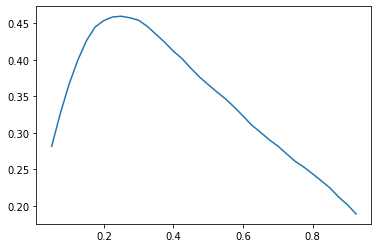

In [38]:
plt.plot(list(scr.keys()),list(scr.values()))

## For vanilla model, we get the best Hamming Score at threshold of 0.25

In [39]:
# Selecting best threshold from above
labels_test = (prediction_test > 0.25).astype(np.int)

print("Accuracy of test tags (at best threshold) are: ", accuracy_score(np.array(y_test), labels_test)*100)
print("Hamming score of test tags (at best threshold) are: ", hamming_score(np.array(y_test), labels_test))

Accuracy of test tags (at best threshold) are:  32.643217909632796
Hamming score of test tags (at best threshold) are:  0.45818518061089836


In [40]:
# Below are the count of tags identified
print("The predicted test tags data looks as follows:")
print(">0: ",len(np.where(np.sum(labels_test, axis = 1)>0)[0]))
print(">1: ",len(np.where(np.sum(labels_test, axis = 1)>1)[0]))
print(">2: ",len(np.where(np.sum(labels_test, axis = 1)>2)[0]))
print(">3: ",len(np.where(np.sum(labels_test, axis = 1)>3)[0]))

print("The actual test data looks as follows:")
print(">0: ",len(np.where(np.sum(np.array(y_test), axis = 1)>0)[0]))
print(">1: ",len(np.where(np.sum(np.array(y_test), axis = 1)>1)[0]))
print(">2: ",len(np.where(np.sum(np.array(y_test), axis = 1)>2)[0]))
print(">3: ",len(np.where(np.sum(np.array(y_test), axis = 1)>3)[0]))

The predicted test tags data looks as follows:
>0:  20919
>1:  8760
>2:  3254
>3:  2314
The actual test data looks as follows:
>0:  19907
>1:  10962
>2:  4071
>3:  2742


### Building model - Pre-trained: VGG16

In [41]:
# Setting up VGG16 model with frozen conv layers
densenn = VGG16(include_top = False, weights='imagenet',input_shape = (35,35,3))

output = densenn.layers[-1].output
dense_model = Model(densenn.input, output)

# Setting the model to be non-trainable
dense_model.trainable = False
for layer in dense_model.layers:
    layer.trainable = False
    
# Checking to ensure the model
layers = [(layer, layer.name, layer.trainable) for layer in dense_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [42]:
# Building model
model = Sequential()
model.add(dense_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(tags.shape[1], activation='sigmoid')) # output layer = number of tags
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 14)                1806      
Total params: 14,782,158
Trainable params: 67,470
Non-trainable params: 14,714,688
_________________________________________________________________


In [43]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr = 0.0005),
              metrics=['accuracy'])

# checkpoint
filepath="model_best_pretrained.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [44]:
dataset = df_input[['loaded_img']]
y = df_input.drop('loaded_img',axis = 1)

# Randomly splitting onto train-test datasets
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train = np.array(X_train.loaded_img.tolist())
X_val = np.array(X_val.loaded_img.tolist())

In [45]:
#n = len(df_input) #Size of data
#X_train = np.array(df_input.loaded_img.tolist())
model.fit(X_train, y_train,        # Training data
          batch_size=512,          # Batch size 
          epochs=75,               # Epochs to train for
          verbose=1,               # Displaying progress
          validation_data=(X_val,y_val),    # 10% validation split for checking movement on validation data
          callbacks=callbacks_list # This parameter ensures that the model weights are saved whenever validation loss decreases
         )

Train on 112082 samples, validate on 12454 samples
Epoch 1/75
112082/112082 [==============================] - 11s 98us/step - loss: 1.2692 - accuracy: 0.7836 - val_loss: 0.4148 - val_accuracy: 0.8549

Epoch 00001: val_loss improved from inf to 0.41477, saving model to model_best_pretrained.hdf5
Epoch 2/75
112082/112082 [==============================] - 10s 88us/step - loss: 0.4211 - accuracy: 0.8549 - val_loss: 0.3477 - val_accuracy: 0.8786

Epoch 00002: val_loss improved from 0.41477 to 0.34769, saving model to model_best_pretrained.hdf5
Epoch 3/75
112082/112082 [==============================] - 10s 93us/step - loss: 0.3669 - accuracy: 0.8752 - val_loss: 0.3318 - val_accuracy: 0.8824

Epoch 00003: val_loss improved from 0.34769 to 0.33175, saving model to model_best_pretrained.hdf5
Epoch 4/75
112082/112082 [==============================] - 10s 91us/step - loss: 0.3498 - accuracy: 0.8807 - val_loss: 0.3240 - val_accuracy: 0.8851

Epoch 00004: val_loss improved from 0.33175 to 0.323

112082/112082 [==============================] - 10s 89us/step - loss: 0.2744 - accuracy: 0.8987 - val_loss: 0.2905 - val_accuracy: 0.8958

Epoch 00034: val_loss did not improve from 0.28991
Epoch 35/75
112082/112082 [==============================] - 10s 87us/step - loss: 0.2733 - accuracy: 0.8990 - val_loss: 0.2898 - val_accuracy: 0.8957

Epoch 00035: val_loss improved from 0.28991 to 0.28976, saving model to model_best_pretrained.hdf5
Epoch 36/75
112082/112082 [==============================] - 10s 88us/step - loss: 0.2722 - accuracy: 0.8995 - val_loss: 0.2900 - val_accuracy: 0.8959

Epoch 00036: val_loss did not improve from 0.28976
Epoch 37/75
112082/112082 [==============================] - 10s 87us/step - loss: 0.2711 - accuracy: 0.8997 - val_loss: 0.2900 - val_accuracy: 0.8959

Epoch 00037: val_loss did not improve from 0.28976
Epoch 38/75
112082/112082 [==============================] - 10s 87us/step - loss: 0.2696 - accuracy: 0.9003 - val_loss: 0.2893 - val_accuracy: 0.8965




Epoch 00073: val_loss did not improve from 0.28924
Epoch 74/75
112082/112082 [==============================] - 10s 87us/step - loss: 0.2471 - accuracy: 0.9077 - val_loss: 0.3057 - val_accuracy: 0.8993

Epoch 00074: val_loss did not improve from 0.28924
Epoch 75/75
112082/112082 [==============================] - 10s 92us/step - loss: 0.2473 - accuracy: 0.9077 - val_loss: 0.3064 - val_accuracy: 0.8987

Epoch 00075: val_loss did not improve from 0.28924


In [46]:
gc.collect()

7273

### Testing Model - Pre-trained

In [47]:
# Load best model
model = load_model('/kaggle/working/model_best_pretrained.hdf5')
print("Model load complete!")

X_test_array = np.array(X_test.loaded_img.tolist())
prediction_train = model.predict(X_train)
prediction_val = model.predict(X_val)
prediction_test = model.predict(X_test_array)

#labels
labels_train = (prediction_train > 0.5).astype(np.int)
labels_val = (prediction_val > 0.5).astype(np.int)
labels_test = (prediction_test > 0.5).astype(np.int)

print("Accuracy of train tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_train), labels_train)*100)
print("Accuracy of validation tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_val), labels_val)*100)
print("Accuracy of test tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_test), labels_test)*100)
print("The accuracy numbers are subset accuracy! i.e a sample is correct only if ALL the classes are predicted correctly!")
print("We are going to use Hemming Score to judge the model.")

Model load complete!
Accuracy of train tags (at 0.5 threshold) are:  23.16429043022073
Accuracy of validation tags (at 0.5 threshold) are:  19.551951180343664
Accuracy of test tags (at 0.5 threshold) are:  19.643263411748645
The accuracy numbers are subset accuracy! i.e a sample is correct only if ALL the classes are predicted correctly!
We are going to use Hemming Score to judge the model.


### Calculating Hamming Score for data

In [48]:
labels_train = (prediction_train > 0.5).astype(np.int)
labels_val = (prediction_val > 0.5).astype(np.int)
labels_test = (prediction_test > 0.5).astype(np.int)

print("The Hamming score is the ratio of [intersection of 1's]/[union of 1's]; where intersection and union is between predicted and true data.")
print("Hamming score of train tags (at 0.5 threshold) are: ", hamming_score(np.array(y_train), labels_train))
print("Hamming score of validation tags (at 0.5 threshold) are: ", hamming_score(np.array(y_val), labels_val))
print("Hamming score of test tags (at 0.5 threshold) are: ", hamming_score(np.array(y_test), labels_test))

The Hamming score is the ratio of [intersection of 1's]/[union of 1's]; where intersection and union is between predicted and true data.
Hamming score of train tags (at 0.5 threshold) are:  0.3103012377842413
Hamming score of validation tags (at 0.5 threshold) are:  0.26858305229912743
Hamming score of test tags (at 0.5 threshold) are:  0.2690229178990156


In [49]:
seq = np.arange(0.05, 0.95, 0.025)
scr = {}

for i in seq:
    labels_val = (prediction_val > i).astype(np.int)
    score = hamming_score(np.array(y_val), labels_val)
    scr[i] = score
    print("Threshold: ",i , " Score: ", score)

Threshold:  0.05  Score:  0.22272998333500982
Threshold:  0.07500000000000001  Score:  0.2601112754276397
Threshold:  0.10000000000000002  Score:  0.29134388286267204
Threshold:  0.12500000000000003  Score:  0.31608375966413543
Threshold:  0.15000000000000002  Score:  0.3353576399244457
Threshold:  0.17500000000000004  Score:  0.3476019370330435
Threshold:  0.20000000000000007  Score:  0.3530853541030995
Threshold:  0.22500000000000003  Score:  0.3543534492647228
Threshold:  0.25000000000000006  Score:  0.3533493733128389
Threshold:  0.2750000000000001  Score:  0.34973349545374594
Threshold:  0.3000000000000001  Score:  0.3427041990716312
Threshold:  0.32500000000000007  Score:  0.33592420105990045
Threshold:  0.3500000000000001  Score:  0.32773406134575234
Threshold:  0.3750000000000001  Score:  0.3195666720196991
Threshold:  0.4000000000000001  Score:  0.31092420105990043
Threshold:  0.4250000000000001  Score:  0.29893073175954177
Threshold:  0.4500000000000001  Score:  0.28965124993

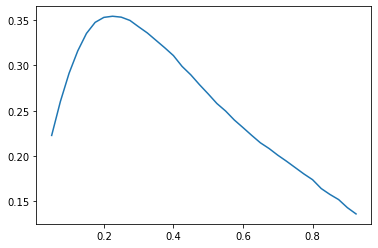

In [50]:
plt.plot(list(scr.keys()),list(scr.values()))

## We get the best Hamming Score at threshold of 0.225

In [53]:
# Selecting best threshold from above
labels_test = (prediction_test > 0.225).astype(np.int)

print("Accuracy of test tags (at best threshold) are: ", accuracy_score(np.array(y_test), labels_test)*100)
print("Hamming score of test tags (at best threshold) are: ", hamming_score(np.array(y_test), labels_test))

Accuracy of test tags (at best threshold) are:  19.10633844473768
Hamming score of test tags (at best threshold) are:  0.35548295079054515


In [54]:
# Below are the count of tags identified
print("The predicted test tags data looks as follows:")
print(">0: ",len(np.where(np.sum(labels_test, axis = 1)>0)[0]))
print(">1: ",len(np.where(np.sum(labels_test, axis = 1)>1)[0]))
print(">2: ",len(np.where(np.sum(labels_test, axis = 1)>2)[0]))
print(">3: ",len(np.where(np.sum(labels_test, axis = 1)>3)[0]))

print("The actual test data looks as follows:")
print(">0: ",len(np.where(np.sum(np.array(y_test), axis = 1)>0)[0]))
print(">1: ",len(np.where(np.sum(np.array(y_test), axis = 1)>1)[0]))
print(">2: ",len(np.where(np.sum(np.array(y_test), axis = 1)>2)[0]))
print(">3: ",len(np.where(np.sum(np.array(y_test), axis = 1)>3)[0]))

The predicted test tags data looks as follows:
>0:  21561
>1:  9428
>2:  3605
>3:  2719
The actual test data looks as follows:
>0:  19907
>1:  10962
>2:  4071
>3:  2742
